In [1]:
from sentence_transformers import CrossEncoder

In [2]:
#Distilled LLMs the decisions of which we try to explain
model1 = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2', max_length=512)
model2 = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512)
model3 = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
model4 = CrossEncoder('cross-encoder/ms-marco-electra-base', max_length=512)

/home/tanya/marco_rerank/marcoenv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
#A Query and a set of 8 relevant passages from the MS MARCO passage reranking dataset
query = "requirements for army"

par1 = "The basic qualifications for enlistment in the U.S. Army include: â¢ being from 17 to 34 years old. â¢ be a U.S. citizen or resident alien, (must have the I-551) â¢ have a high school diploma or equivalent (such as a GED) â¢ be single with no children or married with 2 or less children."
par2 = "Get all of the information you need to learn how to become an Army chaplain, including the specific Army chaplain requirements."
par3 = "Age Requirements: Be between the ages of 17-35 years. Length of Service: 2-6 year commitment/Serve a total of 8 years in the military: Retirement: May Retire after 20 years of qualifying service: Job Choices: 200 jobs to choose from: Medical / Dental Benefits: Medical and dental benefits: Job training opportunities: Specialized job training (AIT) Location of duty"
par4 = "BECOMING AN ARMY CHAPLAIN. 1  You must obtain an ecclesiastical endorsement from your faith group. This endorsement should certify that you are: A clergy person in your denomination or faith group. 2  Educationally, you must: Possess a baccalaureate degree of not less than 120 semester hours."
par5 = "However, after service of three years, additional residency requirements for citizenship can be waived. The Military does not assist in immigration naturalization process. For enlistment purposes, the United States includes Guam, Puerto Rico, U.S. Virgin Islands, The Northern Marianas Islands, American Samoa, Federated States of Micronesia, and the Marshall Islands."
par6 =  "The Army has very specific physical fitness requirements. If you are thinking about joining and want to know what kind of shape you need to be in, these charts, weight and physical fitness , will tell you everything you need to know."
par7 =  "Applicants for active duty or the National Guard MUST be U.S. citizens. Permanent residents can ONLY apply for the Army Reserve. Be able to receive a favorable National Agency Security Clearance. Pass a physical exam at one of our Military Entrance Processing Stations (MEPS)."
par8 =  "Serving as an Army Reserve chaplain means you'll still have a civilian job, but you'll train each month close to home and complete a two-week training exercise once a year. This way you will be trained and ready if called."

In [4]:
#Predicting each passage's relevance to the query based on different LLMs 
scores1 = model1.predict([(query, par1), (query, par2) , (query, par3), (query,par4),(query, par5), (query, par6) , (query, par7), (query,par8)])
scores2 = model2.predict([(query, par1), (query, par2) , (query, par3), (query,par4),(query, par5), (query, par6) , (query, par7), (query,par8)])
scores3 = model3.predict([(query, par1), (query, par2) , (query, par3), (query,par4),(query, par5), (query, par6) , (query, par7), (query,par8)])
scores4 = model4.predict([(query, par1), (query, par2) , (query, par3), (query,par4),(query, par5), (query, par6) , (query, par7), (query,par8)])

In [5]:
#Function to generate the document order from the output of various ranking models 
def order_func(s):
    return sorted(range(len(s)), key=lambda k: -s[k])

ord1,ord2,ord3,ord4 = order_func(scores1),order_func(scores2),order_func(scores3),order_func(scores4)

In [6]:
#EXS Implementation using LIME library
from lime.lime_text import LimeTextExplainer
class_names = ['irrelevant','relevant']
explainer = LimeTextExplainer(class_names=class_names)
import numpy as np

def topk_binary(texts):
    rel = np.zeros((len(texts),2),dtype=np.float32)
    for i in range(len(texts)):
        if(model1.predict([query,texts[i]])>=scores1[ord1[0]] ):
            rel[i][1]=1.0
        else:
            rel[i][0]=1.0
    return rel

def score_based(texts):
    rel = np.zeros((len(texts),2),dtype=np.float32)
    for i in range(len(texts)):
        rel[i][1] = 1 - (scores1[ord1[0]]-model1.predict([query,texts[i]]))/scores1[ord1[0]]
        rel[i][0] = 1 - rel[i][1]
    return rel
    
def rank_based(texts):
    rel = np.zeros((len(texts),2),dtype=np.float32)
    for i in range(len(texts)):
        pred_rel = model1.predict([query,texts[i]])

        if(pred_rel <scores1[ord1[4]] ):
            rel[i][0]=1.0
        else:
            idx = 0
            while(pred_rel < scores1[ord1[idx]]):
                idx+=1
             
            rel[i][1]=1.0 - idx/4.0
    return rel

In [7]:
#Aggregate attributions for entire ordered list
def dict_aggregate(dict1,dict2):
    result = dict(dict1)
    for key, value in dict2.items():
        result[key] = result.get(key, 0) + value 
    return result
    
exp_score=dict()
exp_topk=dict()
exp_rank= dict()
pars = [par1.lower(),par2.lower(),par3.lower(),par4.lower(),par5.lower(),par6.lower(),par7.lower(),par8.lower()]

for i in range(8):
    exp_score_dict = dict(explainer.explain_instance(pars[i], score_based, num_features=8).as_list())
    print(exp_score_dict)
    exp_topk_dict = dict(explainer.explain_instance(pars[i], topk_binary, num_features=8).as_list())
    exp_rank_dict = dict(explainer.explain_instance(pars[i], rank_based, num_features=8).as_list())
    print(i,end="")

    exp_score = dict_aggregate(exp_score,exp_score_dict)
    exp_topk = dict_aggregate(exp_topk,exp_topk_dict)
    exp_rank = dict_aggregate(exp_rank,exp_rank_dict)


    


{'army': 0.7226420513020626, 'must': 0.4365111465244764, 'qualifications': 0.2092682880252392, 'â': -0.15616262708169495, 'alien': -0.050939606404377294, 'or': 0.03955253182352023, 'include': 0.03204596196711165, 'basic': 0.02560798308630609}
0{'army': 0.4928065217018767, 'requirements': 0.43624982587477096, 'chaplain': -0.19292479731923323, 'how': -0.10734809930135135, 'information': -0.0899513001756911, 'learn': -0.054671779648850866, 'get': -0.04810066789138331, 'become': -0.041655764121959274}
1{'requirements': 0.5210060463637555, 'military': 0.5089400131120988, 'years': -0.08812511390525647, 'age': -0.07314926993745297, 'dental': -0.061176353922927, 'job': -0.05744141958155455, 'commitment': -0.042707555538594434, 'service': -0.041587565672572574}
2{'must': 0.33909395293726535, 'army': 0.3347773209542774, 'chaplain': -0.12490758522071853, 'endorsement': -0.04880053025562304, 'you': -0.04299077608184588, 'faith': -0.04144965610952791, 'not': -0.036936611545600795, 'becoming': -0.03

In [8]:
#Top 8 features by absolute attributtion sorted acc to 3 different attribution algorithms
sorted_exp_score = sorted(exp_score.items(), key=lambda item: abs(item[1]), reverse=True)[:8]
sorted_exp_topk = sorted(exp_topk.items(), key=lambda item: abs(item[1]), reverse=True)[:8]
sorted_exp_rank = sorted(exp_rank.items(), key=lambda item: abs(item[1]), reverse=True)[:8]

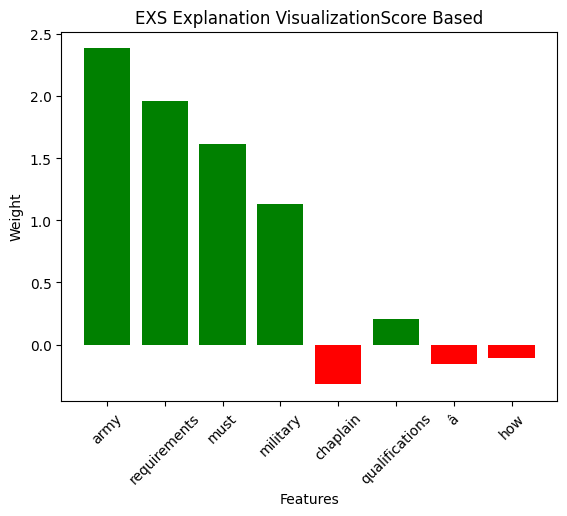

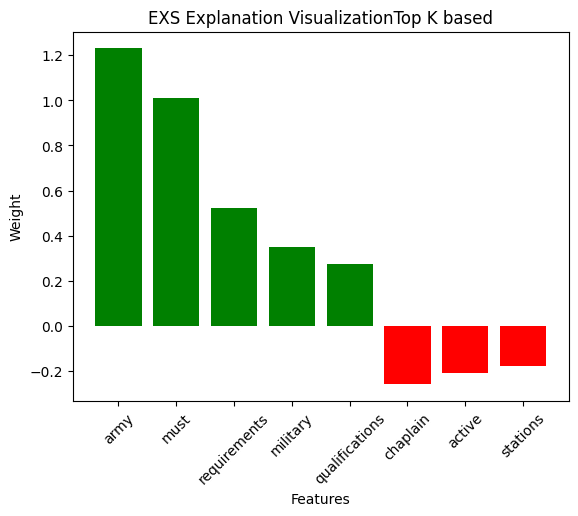

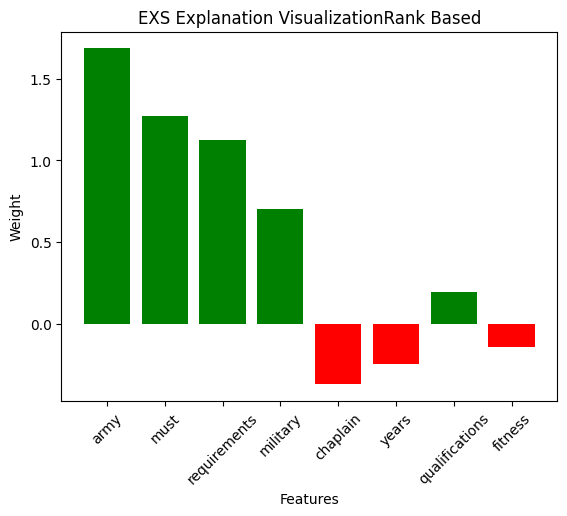

In [9]:
#Visualize attributions computed above
import matplotlib.pyplot as plt

def plot_func(viz_dict,algo):
    features, weights = zip(*viz_dict)
    plt.bar(features, weights, color=['green' if w > 0 else 'red' for w in weights])
    plt.xlabel('Features')
    plt.ylabel('Weight')
    plt.title('EXS Explanation Visualization'+algo)
    plt.xticks(rotation=45)
    plt.show()

plot_func(sorted_exp_score, "Score Based")
plot_func(sorted_exp_topk, "Top K based")
plot_func(sorted_exp_rank, "Rank Based")

    

